In [1]:
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np

def pearson_spearman(x, y):
    pearson_corr, pearson_p_value = scipy.stats.pearsonr(x, y)
    print(f"Pearson correlation coefficient: {pearson_corr:.4f}, p-value: {pearson_p_value:.4g}")

    spearman_corr, spearman_p_value = scipy.stats.spearmanr(x, y)
    print(f"Spearman correlation coefficient: {spearman_corr:.4f}, p-value: {spearman_p_value:.4g}")

In [8]:
# EXAMPLE MAKE ONE_TO_ONE_PEAKS THEN SAVE IT
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np

species = 'cow'

both_df = pd.read_csv(f"/home/azstephe/liverRegression/regression_liver/data/splits/{species}Mouse/{species}ToMouse_liver_{species}Enhancer_mouseEnhancer_test_wawb.narrowPeak", sep="\t", header=None)
mac_qn = pd.read_csv(f"/home/azstephe/liverRegression/regression_liver/data/log/{species}_liver_pos_ALL.bed", sep="\t", header=None)
mouse_qn = pd.read_csv("/home/azstephe/liverRegression/regression_liver/data/log/mouse_liver_pos_ALL.bed", sep="\t", header=None)

unique1_2 = both_df[~both_df.duplicated(subset=[1, 2], keep=False)] # entries with unique mac mapped to mouse start and end
all_unique = unique1_2[~unique1_2.duplicated(subset=[11,12], keep=False)]

#### FUNCTIONS

def pearson_spearman(x, y):
    pearson_corr, pearson_p_value = scipy.stats.pearsonr(x, y)
    print(f"Pearson correlation coefficient: {pearson_corr:.4f}, p-value: {pearson_p_value:.4g}")

    spearman_corr, spearman_p_value = scipy.stats.spearmanr(x, y)
    print(f"Spearman correlation coefficient: {spearman_corr:.4f}, p-value: {spearman_p_value:.4g}")
    
def collapse_if_identical(lst):
    return lst[0] if all(x == lst[0] for x in lst) else lst
    

# takes in list and returns peak with largest signal
def keep_largest_signal(lst, qn_df):
    if isinstance(lst, list):
        maxPeakName = ''
        maxPeakStrength = 0
        for peak in lst:
            matching_rows = qn_df[qn_df[3] == peak]
            if not matching_rows.empty:
                signal = matching_rows[4].iloc[0]
                if signal > maxPeakStrength:
                    maxPeakStrength = signal
                    maxPeakName = peak
        return maxPeakName
    else: 
        return lst

# def overlap(start1, end1, start2, end2):
#     return max(0, min(end1, end2)-max(start1, start2))

def get_biggest_overlap(lst, col, df):
    maxOverlap = 0
    maxPeakOverlap = ""
    for peak in lst:
        row = df[df[col] == peak].iloc[0] #iloc bc possible to return multiple rows (never will based on th
        overlap = max(0, min(row[2], row[12])-max(row[1], row[11]))
        if overlap > maxOverlap:
            maxOverlap = overlap
            maxPeakOverlap = peak
    return peak

#### COL1,2 DUPLICATES

duplicates3 = both_df[both_df.duplicated(subset=[1, 2], keep=False)] # entries with duplicated mac mapped to mouse start and end 
grouped_dups3 = duplicates3.groupby([1, 2])[3].apply(list).reset_index(name='col3')

# grouped dups: start | end | [peaks with these endpoints]
grouped_dups3['col3'] = grouped_dups3['col3'].apply(collapse_if_identical) 

grouped_dups3['col3'] = grouped_dups3['col3'].apply(lambda x: keep_largest_signal(x, mac_qn)) # redundant endpoints now map to 1 peak in col3
grouped_dups3 = grouped_dups3[grouped_dups3['col3'] != ''] # remove macaque peaks that aren't large enough

# df of duplicated col1,2 with strongest peak
keep_strongestcol3 = duplicates3.merge(grouped_dups3[['col3']], left_on=3, right_on='col3', how='inner').drop('col3', axis=1) # keeps the strongest signal in col3 for redundant endpoints

#### COL11,12 DUPLICATES

grouped_dups13 = keep_strongestcol3.groupby([11, 12])[13].apply(list).reset_index(name='col13')
grouped_dups13['col13'] = grouped_dups13['col13'].apply(collapse_if_identical)

grouped_dups13['col13'] = grouped_dups13['col13'].apply(lambda x: keep_largest_signal(x, mouse_qn))
grouped_dups13 = grouped_dups13[grouped_dups13['col13'] != '']

keep_strongestcol13 = keep_strongestcol3.merge(grouped_dups13[['col13']], left_on=13, right_on='col13', how='inner').drop('col13', axis=1)

unique_endpoints = keep_strongestcol13 #rows with unique endpoints from the duplicated endpoints set

####

# col3 peakname duplicates with different endpoints
still_dups_col3 = unique_endpoints[unique_endpoints.duplicated(subset=[3], keep=False)]

# col3peaks | [col13 peaks intersecting col3 peak]
grouped_dcol3 = still_dups_col3.groupby(3)[13].apply(list).reset_index(name='col13')

# get the col13 peak with most overlap of col3
grouped_dcol3['col13'] = grouped_dcol3['col13'].apply(lambda x: get_biggest_overlap(x, 13, still_dups_col3))

merged3 = still_dups_col3.merge(grouped_dcol3[[3, 'col13']], left_on=[3, 13], right_on=[3, 'col13'], how='left', indicator=True)

remove3 = merged3[merged3['_merge'] == 'left_only'].drop(columns=['_merge']) # col13 is what we want to remove

unique_endpoints_subset = unique_endpoints.iloc[:,:20]
remove3_subset = remove3.iloc[:,:20]

# all col3 entries unique
unique3 = unique_endpoints[~unique_endpoints_subset.apply(tuple, axis=1).isin(remove3_subset.apply(tuple, axis=1))] 

####

# col13 peakname duplicates with different endpoints
still_dups_col13 = unique3[unique3.duplicated(subset=[13], keep=False)]

# col13peaks | [col3 peaks intersecting col13 peak]
grouped_dcol13 = still_dups_col13.groupby(13)[3].apply(list).reset_index(name='col3')

# get the col3 peak with most overlap of col13
grouped_dcol13['col3'] = grouped_dcol13['col3'].apply(lambda x: get_biggest_overlap(x, 3, still_dups_col13))

merged13 = still_dups_col13.merge(grouped_dcol13[[13, 'col3']], left_on=[3, 13], right_on=['col3', 13], how='left', indicator=True)

remove13 = merged13[merged13['_merge'] == 'left_only'].drop(columns=['_merge'])

unique3_subset = unique3.iloc[:, :20]
remove13_subset = remove13.iloc[:, :20]

# Identify rows in u3 that are NOT in remove3
filtered_peaks_unique = unique3[~unique3_subset.apply(tuple, axis=1).isin(remove13_subset.apply(tuple, axis=1))]

full_unique = pd.concat([all_unique, filtered_peaks_unique])

# Sort by column '1'
one_to_one_peaks = full_unique.sort_values(by=1).reset_index(drop=True)
one_to_one_peaks.to_csv(f'/home/azstephe/liverRegression/regression_liver/data/test_splits/oneToOnePeaks/{species}_mouse.bed', header=None, sep='\t')
one_to_one_peaks
##############################



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,chr2,3228517,3228757,peak14076,-1,.,-1,-1,-1,118,chr2,3228532,3229401,peak11427,1000,.,16.72388,152.95140,149.78862,727
1,chr1,4571489,4572079,peak15034,-1,.,-1,-1,-1,252,chr1,4571316,4572253,peak23,1000,.,11.87366,175.62753,172.38829,420
2,chr2,6072068,6072444,peak13865,-1,.,-1,-1,-1,251,chr2,6072019,6072463,peak11460,1000,.,10.44881,99.04040,96.09357,249
3,chr2,8754215,8754576,peak13890,-1,.,-1,-1,-1,141,chr2,8754014,8754734,peak11485,1000,.,14.63608,148.44099,145.29451,312
4,chr2,8924820,8925196,peak13893,-1,.,-1,-1,-1,186,chr2,8924676,8925342,peak11488,1000,.,20.63259,516.08203,512.01422,337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,chr1,194722465,194722630,peak17035,-1,.,-1,-1,-1,71,chr1,194722426,194722640,peak1958,955,.,5.29117,23.96858,21.54324,105
305,chr1,194839398,194839484,peak17036,-1,.,-1,-1,-1,37,chr1,194839309,194839662,peak1959,887,.,6.61396,35.47048,32.91997,105
306,chr1,194879587,194879938,peak17037,-1,.,-1,-1,-1,151,chr1,194879214,194880183,peak1960,1000,.,13.37815,151.28612,148.12956,512
307,chr1,195016785,195017251,peak17039,-1,.,-1,-1,-1,176,chr1,195017180,195017466,peak1968,1000,.,5.09901,40.06577,37.47466,169


# of same sign for true difference and predicted difference: 466 / 798 = 0.5839598997493735 %
# of same sign for true difference and averaged predicted difference: 240 / 399.0 = 0.6015037593984962%
Pearson correlation coefficient: 0.2124, p-value: 1.37e-09
Spearman correlation coefficient: 0.2022, p-value: 8.237e-09
None


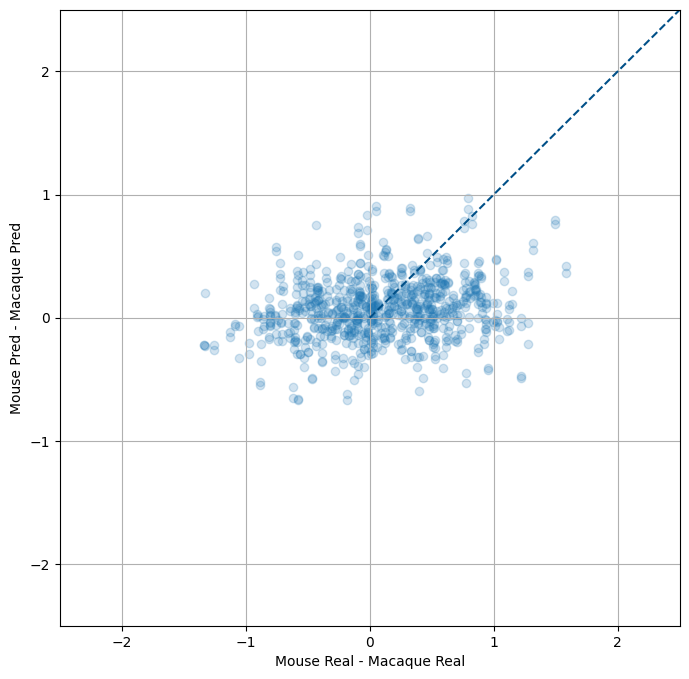

In [11]:
species = 'macaque'
model = 'bdbi7l3n'

mac_qn = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/log/{species}_liver_pos_ALL.bed', sep="\t", header=None)
mouse_qn = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/log/mouse_liver_pos_ALL.bed', sep="\t", header=None)

one_to_one_peaks = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/test_splits/oneToOnePeaks/{species}_mouse.bed', header=None, sep='\t')
pred_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/model_outputs/{model}/activations_{species}_TEST.csv', header=None)
val1_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/test_splits/amy_test1/{species}_liver_TEST_500bp.bed', header=None, delim_whitespace=True).iloc[:,4]
# val2_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/splits/val2/{species}_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]
val3_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/test_splits/log_test3/{species}_liver_TEST_500bp.bed', header=None, delim_whitespace=True).iloc[:,4]

val2_df = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/test_splits/log_test2/{species}_liver_TEST_500bp.bed', header=None, sep="\t").rename(columns={0: 'mac_chr'})

val1_len = 2*len(val1_df)
val2_len = 2*len(val2_df)

####################### make the ____ doubled predicted and true df
peaks = one_to_one_peaks[[4, 14]]

merged_df = peaks.merge(mac_qn, how='left', left_on=4, right_on=3, suffixes=('', '_mac'))

# Merge the result with df3 on col13 and df3['col3']
merged_df = merged_df.merge(mouse_qn, how='left', left_on=14, right_on=3, suffixes=('_MAC', '_mouse'))

# Subtract col4 values from df2 and df3
# merged_df['result'] = merged_df['4_mac'] - merged_df['4_mouse']
# res = merged_df[['4', 14, '4_mac', '4_mouse', 'result']]
# nan = res[res.isna().any(axis=1)]

# nan

####################### 

doubled_val2_df = pd.concat([val2_df, val2_df]).sort_index(kind='mergesort').reset_index(drop=True)

pred_val2_df = pred_df.iloc[val1_len:val1_len + val2_len].reset_index(drop=True)

doubled_combined = pd.concat([doubled_val2_df, pred_val2_df], axis=1)

mac_val2_real_pred = doubled_combined.rename(columns={4: 'mac_true', 0:'mac_pred'})

merged_mac_real_pred = peaks.merge(mac_val2_real_pred, how='left', left_on=4, right_on=3).drop(14, axis=1)
# m_mac_pred = merged_mac_real_pred[~merged_mac_real_pred[3].isin(nan['3_mac'])].reset_index(drop=True)
m_mac_pred = merged_mac_real_pred.rename(columns={3:'mac_peak'}).drop(4, axis=1)

####################### make the mouse doubled predicted and true df

mouse_pred = pd.read_csv(f'/home/azstephe/liverRegression/regression_liver/data/model_outputs/{model}/activations_mouse_TEST.csv', sep="\t", header=None)
mouse_real_neg=pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/test_splits/neg/mouse_liver_TEST_500bp.bed', sep="\t", header=None)
mouse_real_pos=pd.read_csv('/home/azstephe/liverRegression/regression_liver/data/test_splits/log_pos/mouse_liver_TEST_500bp.bed', sep="\t", header=None)

real_neg_len = 2*len(mouse_real_neg)
real_pos_len = 2*len(mouse_real_pos)

mouse_pred_pos = mouse_pred.head(real_pos_len).reset_index(drop=True)

doubled_mouse_real_pos = pd.concat([mouse_real_pos, mouse_real_pos]).sort_index(kind='mergesort').reset_index(drop=True)


doubled_mouse_real_pos = doubled_mouse_real_pos.rename(columns={0:'mouse_chr'})
mouse_pos_real_pred = pd.concat([doubled_mouse_real_pos.drop(columns=5), mouse_pred_pos], axis=1)
mouse_pos_real_pred = mouse_pos_real_pred.rename(columns={4:'mouse_true', 0:'mouse_pred'}).reset_index(drop=True)


merged_mouse_pred = peaks.merge(mouse_pos_real_pred, how='left', left_on=14, right_on=3)

m_mouse_pred = merged_mouse_pred.rename(columns={3:'mouse_peak'}).drop([14], axis=1)

####################### make bigboss mouse + query predicted and real info

bigboss = pd.concat([m_mouse_pred, m_mac_pred], axis=1)

bigboss['true'] = bigboss['mouse_true']-bigboss['mac_true']
bigboss['pred'] = bigboss['mouse_pred']-bigboss['mac_pred']

mouse_av = (bigboss.loc[::2, 'mouse_pred'].values + bigboss.loc[1::2, 'mouse_pred'].values) / 2
mac_av = (bigboss.loc[::2, 'mac_pred'].values + bigboss.loc[1::2, 'mac_pred'].values) / 2

# Add the averages back to the DataFrame as a new column
bigboss.loc[::2, 'mouse_pred_avg'] = mouse_av  # Assign averages to even indices only
bigboss.loc[::2, 'mac_pred_avg'] = mac_av 
bigboss['avg_pred'] = bigboss['mouse_pred_avg']-bigboss['mac_pred_avg']


same_sign = np.sign(bigboss['true']) == np.sign(bigboss['pred'])
print(f'# of same sign for true difference and predicted difference: {same_sign.sum()} / {len(bigboss)} = {same_sign.sum() / len(bigboss)} %')

same_sign = np.sign(bigboss.loc[::2]['true']) == np.sign(bigboss.loc[::2]['avg_pred'])
print(f'# of same sign for true difference and averaged predicted difference: {same_sign.sum()} / {len(bigboss) / 2} = {same_sign.sum() / (len(bigboss) / 2)}%')

x = bigboss['true']
y = bigboss['pred']

print(pearson_spearman(x, y))

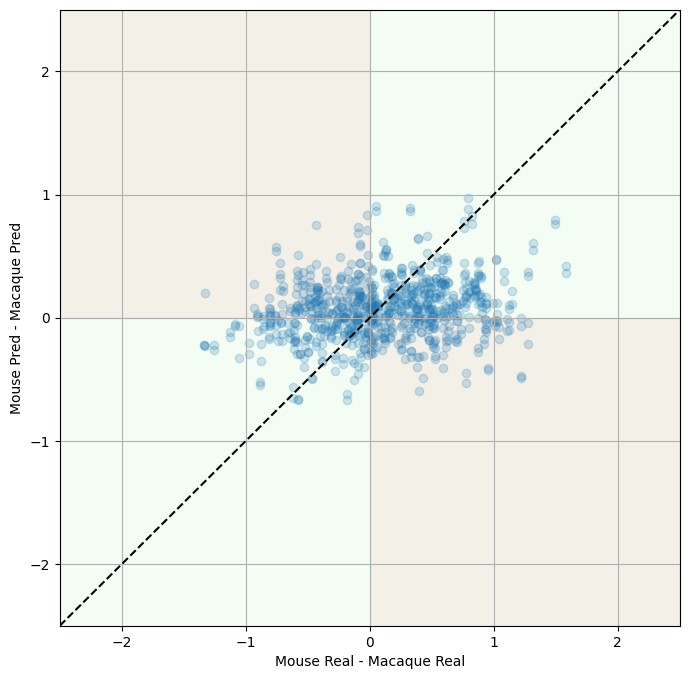

In [13]:
plt.figure(figsize=(6, 6))
plt.axhspan(0, 2.5, xmin=0, xmax=1, color='lightgreen', alpha=0.1)  # 1st quadrant
plt.axhspan(-2.5, 0, xmin=0, xmax=1, color='lightgreen', alpha=0.1)  # 3rd quadrant
plt.axhspan(0, 2.5, xmin=0, xmax=0.5, color='lightcoral', alpha=0.1)  # 2nd
plt.axhspan(-2.5, 0, xmin=0.5, xmax=1, color='lightcoral', alpha=0.1)
plt.axis([-2.5, 2.5, -2.5, 2.5])
plt.scatter(x, y, alpha=0.2)
plt.plot([-2.5, 2.5], [-2.5, 2.5], color='black', linestyle='--', label='y = x')
plt.xlabel(f'Mouse Real - {species.capitalize()} Real')
plt.ylabel(f'Mouse Pred - {species.capitalize()} Pred')
# plt.title(f'Foldchange diff in real vs. predicted for model: {model}')
plt.grid(True)
plt.show()